In [19]:
import os
from pathlib import Path

import numpy as np
import scipy as sp
import scipy.spatial

from matplotlib import pyplot as plt
from sklearn.manifold import MDS
from sklearn import manifold
from sklearn.decomposition import PCA

import ot
import shutil
from tqdm import tqdm

import ipynbname
import torch
from torch.autograd.functional import jacobian

import multiprocessing as mp

## IMPORT USER DEFINED LIBRARIES ##################################################################
import utils


# Utils

In [20]:
import secrets

def simplex_grid(N=20):
    """Generate points on a 2D simplex grid (triangle) with N divisions per edge."""    
    N = 20
    pts = []
    for l in range(N + 1):
        for j in range(N + 1 - l):
            k = N - l - j
            pts.append((l / N, j / N, k / N))
    pts=np.array(pts)
    return pts

def random_rbf_deformation(pts,
                           num_ctrl=20,
                           sigma=0.3,
                           max_disp=0.3,
                           seed=None):
    """
    pts: (N, 2) array in some domain, e.g. [0,1]^2
    num_ctrl: number of random control points
    sigma: RBF width (in units of the domain)
    max_disp: max magnitude of control displacements (same units as coords)
    """
    if seed is None:
        seed = secrets.randbits(256)
    rng = np.random.default_rng(seed)

    # 1) Random control points within bounding box of pts
    mins = pts.min(axis=0)
    maxs = pts.max(axis=0)
    ctrl_pts = rng.uniform(mins, maxs, size=(num_ctrl, 2))

    # 2) Random displacements assigned to control points
    ctrl_disp = rng.uniform(-max_disp, max_disp, size=(num_ctrl, 2))

    # 3) Compute RBF weights for each data point
    #    shape: (N, num_ctrl)
    diff = pts[:, None, :] - ctrl_pts[None, :, :]      # (N, K, 2)
    sqdist = np.sum(diff**2, axis=-1)                  # (N, K)
    weights = np.exp(-sqdist / (2.0 * sigma**2))       # (N, K)

    # Normalize weights so they don't blow up
    weights_sum = np.sum(weights, axis=1, keepdims=True) + 1e-12
    weights = weights / weights_sum

    # 4) Interpolated displacement field at pts
    disp = weights @ ctrl_disp                          # (N, 2)

    # 5) Deformed points
    pts_deformed = pts + disp
    return pts_deformed, disp, ctrl_pts, ctrl_disp, seed


def plot_point_cloud(pts, title='Point Cloud'):
    """Plot 2D point cloud. pts is (N, 2) array."""
    plt.figure(figsize=(4,4))
    plt.scatter(pts[:,0], pts[:,1], s=10, c='k')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid()
    plt.show() 

def compute_distance_matrix(pts):
    """Compute pairwise Euclidean distance matrix for pts."""
    diff = pts[:, None, :] - pts[None, :, :]  # (N, N, 2)
    dist_matrix = np.sqrt(np.sum(diff**2, axis=-1))  # (N, N)
    return dist_matrix  


def run_with_timeout(func, args=(), timeout=20):
    """
    Runs func(*args) in a separate process.
    If it finishes before timeout, returns its output.
    If not, kills the process and returns None.
    """

    q = mp.Queue()

    # Wrapper to capture output in queue
    def wrapper(q, func, args):
        out = func(*args)
        q.put(out)

    p = mp.Process(target=wrapper, args=(q, func, args))
    p.start()
    p.join(timeout)

    if p.is_alive():
        # timeout → kill process
        p.terminate()
        p.join()
        return None

    # If function finished, get its return value
    if not q.empty():
        return q.get()
    return None


# Generate

Number of points in simplex grid with N=20: 231


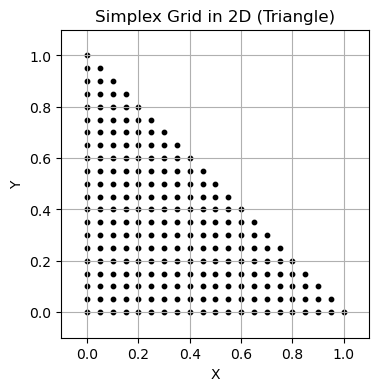

In [21]:
# ----------------------------------------------
# Generate simplex grid --> triangle (3 templates)
# ---------------------------------------------- 
N = 20
pts = simplex_grid(N) 
print('Number of points in simplex grid with N={}: {}'.format(N, pts.shape[0]))

plot_point_cloud(pts[:, :2], title='Simplex Grid in 2D (Triangle)')

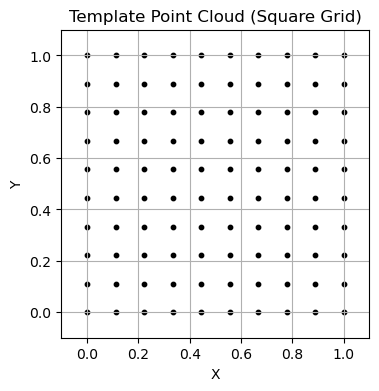

In [22]:
# ----------------------------------------------
# Generate a template cloud point in 2D that is a uniform grid in a square
# ----------------------------------------------
n_pts_per_side = 10
x = np.linspace(0, 1, n_pts_per_side)
y = np.linspace(0, 1, n_pts_per_side)
X, Y = np.meshgrid(x, y)
template_pts = np.vstack([X.ravel(), Y.ravel()]).T  # shape (n_pts_per_side**2, 2)          

plot_point_cloud(template_pts, title='Template Point Cloud (Square Grid)')
 

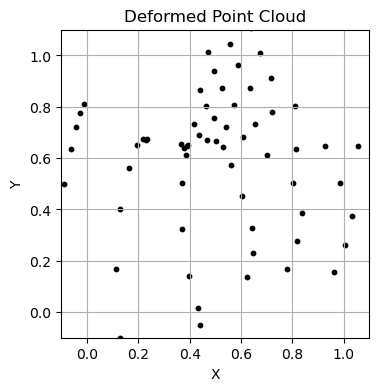

In [23]:
# -----------------------------------------------
# Example: Generate a random deformation of the template cloud
# -----------------------------------------------
deformed_pts, disp, ctrl_pts, ctrl_disp, seed = random_rbf_deformation(
    template_pts,
    num_ctrl=15,
    sigma=0.2,
    max_disp=1,
)

plot_point_cloud(deformed_pts, title='Deformed Point Cloud')


In [24]:
# ----------------------------------------------
# Load (target)template and the first three deformed point clouds 
# ----------------------------------------------
output_dir = Path('./20-Exp-generated_data')

# Load template distance matrix to use as target
template_data = np.load(output_dir / 'template_point_cloud.npz')     
template_dist_matrix = template_data['distance_matrix']
target_dist_matrix = template_dist_matrix
target_measure = ot.unif(template_dist_matrix.shape[0])

# Load first three deformed point clouds   
assert len(os.listdir(output_dir)) >= 4, "Need at least 3 deformed point clouds saved."     
deformed_dist_matrices = []
deformed_measures = []
for idx in range(1, 4):
    deformed_data = np.load(output_dir / f'deformed_point_cloud_{idx}.npz')
    deformed_pts = deformed_data['points']
    deformed_dist_matrix = deformed_data['distance_matrix']
    deformed_dist_matrices.append(deformed_dist_matrix)
    deformed_measures.append(ot.unif(deformed_dist_matrix.shape[0]))

# ----------------------------------------------
# Load distance between barycenters and target data
# ----------------------------------------------
bary_dist_data = np.load(output_dir / 'Bary_distances_to_target.npz')
simplex_grid_points = bary_dist_data['simplex_grid_points']
simplex_gromov_wasserstein_distances_to_target = bary_dist_data['simplex_gromov_wasserstein_distances_to_target']



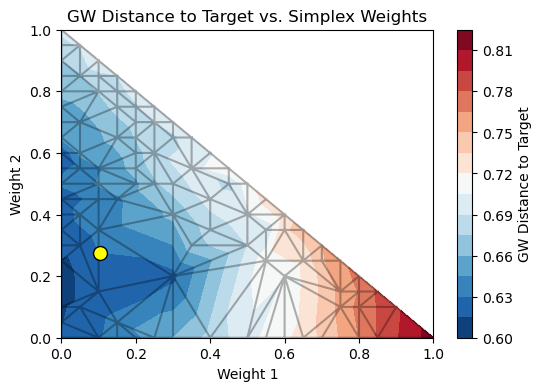

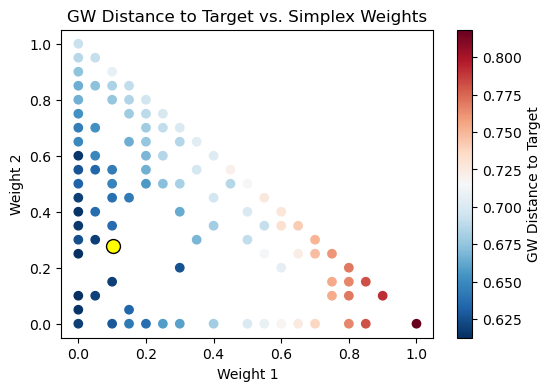

In [25]:
import matplotlib.tri as tri

# Compute analysis of target 
_, lambdas = utils.get_lambdas_constraints(deformed_dist_matrices,deformed_measures,target_dist_matrix, target_measure)

# Clean up NaN values for plotting
z = simplex_gromov_wasserstein_distances_to_target
mask = np.isnan(z)
z_masked = z[~mask]
x_grid_points = simplex_grid_points[~mask,0]
y_grid_points = simplex_grid_points[~mask,1]

# Plot GW distances to target vs. simplex weights
plt.figure(figsize=(6,4))
plt.tricontourf(x_grid_points, y_grid_points, z_masked, levels=14, cmap="RdBu_r")
plt.colorbar(label='GW Distance to Target')
plt.xlabel('Weight 1')
plt.ylabel('Weight 2')
plt.title('GW Distance to Target vs. Simplex Weights')
# Add triangulation grid
triang = tri.Triangulation(x_grid_points, y_grid_points)
plt.triplot(triang, color='k', alpha=0.3)
plt.scatter(lambdas[0], lambdas[1], color='yellow', s=100, edgecolor='k', label='Computed Weights')
plt.show()

# Scatter plot of GW distances to target vs. simplex weights
plt.figure(figsize=(6,4))
plt.scatter(x_grid_points, y_grid_points, c=z_masked, cmap='RdBu_r')
plt.colorbar(label='GW Distance to Target')
plt.xlabel('Weight 1')
plt.ylabel('Weight 2')
plt.title('GW Distance to Target vs. Simplex Weights')
plt.scatter(lambdas[0], lambdas[1], color='yellow', s=100, edgecolor='k', label='Computed Weights')
plt.show()


# Objective 1: Compute a gradient at some point and plot in graph

In [26]:
# ----------------------------
# Device
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------------
# Convert data to torch
# ---------------------------------------------------
Cs_torch = [torch.from_numpy(C).float().to(device) for C in deformed_dist_matrices]
ps_torch = [torch.from_numpy(p).float().to(device) for p in deformed_measures]
C_target = torch.from_numpy(target_dist_matrix).float().to(device) 
p_target = torch.from_numpy(target_measure).float().to(device)


# lambda as a torch parameter (on simplex or not, up to you)
lambda_init = torch.ones(len(Cs_torch), device=device) / len(Cs_torch)
lambda_vec = lambda_init.clone().requires_grad_(True)

In [ ]:
def compute_prod_torch(p, check_zeros=True):
    # p: (N,) or (S,N) depending on your case; here I assume (N,)
    inv_p = torch.where(p == 0.0, torch.ones_like(p), 1.0 / p) if check_zeros \
            else 1.0 / p
    return torch.outer(inv_p, inv_p)  # (N,N)

def barycenter_from_lambda(lam, Ts, Cs, prod):
    """
    lam: (S,) tensor (sum=1 if you want a true simplex)
    Ts:  list of S tensors (N, ns) or (ns, N) depending on target/source
    Cs:  list of S tensors (ns, ns)
    prod: (N,N) tensor
    """
    S = len(Ts)
    B_list = []
    for s in range(S):
        # target=False case: C = sum λ_s T_s C_s T_s^T
        B_s = Ts[s] @ Cs[s] @ Ts[s].T  # (N,N)
        B_list.append(B_s)

    # linear combination in λ
    C = sum(lam[s] * B_list[s] for s in range(S))  # (N,N)
    C = C * prod  # elementwise
    return C




def compute_gradient(lambda_init, Cs_torch, ps_torch, C_target, p_target):
    lambda_vec = lambda_init.clone().requires_grad_(True)

    # ---------------------------------------------------
    # Select barycenter support size and background measure 
    # ---------------------------------------------------
    M = template_dist_matrix.shape[0]  # Barycenter support size
    p_b_np = ot.unif(M)
    p_b_torch = torch.from_numpy(p_b_np).float().to(device)

    # ---------------------------------------------------
    # Compute Gromov-Wasserstein barycenter and its Jacobian w.r.t. lambda
    # ---------------------------------------------------

    # def GWbarycenter(lam):
    #    GWbary = ot.gromov.gromov_barycenters(M, Cs = Cs_torch, ps = ps_torch, p=p_target, lambdas=lam, C=torch.rand(M, M).to(device).requires_grad_(True), loss_fun='square_loss',stop_criterion="barycenter")
    #    #print("Barycenter inside GWbarycenter:", GWbary)
    #    return GWbary
    
    def GWbarycenter(lam):
        return barycenter_from_lambda(lam,,Cs_torch,



    # Jacobian
    GWBary_Jacobian = jacobian(GWbarycenter, lambda_vec)
    print("Jacobian norm:", GWBary_Jacobian.norm().item())
    print("Jacobian sample:", GWBary_Jacobian.view(-1)[:10])
    
    # Barycenter
    lambda_clean = lambda_vec.detach().clone()
    Z_star = GWbarycenter(lambda_clean)
    #print("Barycenter:", Z_star)


    #---------------------------------------------------
    # Compute derivative of GW loss resp to barycenter cost matrix
    #---------------------------------------------------

    def GW_loss(C_bary):
        loss = ot.gromov.gromov_wasserstein2(C_bary, C_target, p_b_torch, p_target, 'square_loss')
        return loss

    Z_star = Z_star.detach()  # detach to avoid double grad
    Z_star = Z_star.requires_grad_(True) 
    GWloss_Jacobian = jacobian(GW_loss, Z_star)
    #print("GW loss Jacobian:", GWloss_Jacobian)

    #---------------------------------------------------
    # Compute derivative of GW loss resp to barycenter cost matrix via envelope theorem
    #---------------------------------------------------
    X = C_target
    p_X_torch = p_target

    # Solve GW between Z_star and X (POT)
    T_np = ot.gromov.gromov_wasserstein(
        Z_star.detach(),  # don't backprop through the solver
        X.detach(),
        p_b_torch.detach(),
        p_X_torch.detach(),
        loss_fun='square_loss',                                                                                                                                                                                                                                                                                                       
    )

    # Make sure T is a torch tensor on the right device
    if not isinstance(T_np, torch.Tensor):
        T = torch.from_numpy(T_np).to(Z_star.device, dtype=Z_star.dtype)
    else:
        T = T_np.to(Z_star.device, dtype=Z_star.dtype)

    T_fixed = T.detach()  # VERY IMPORTANT: fixed plan


    #---------------------------------------------------
    # Define GW cost with fixed transport plan to use envelope theorem
    #---------------------------------------------------
    def gw_cost_fixed_plan(Z, X, T_fixed):
        """
        GW(Z, X; T_fixed) with squared loss, using T as a constant.
        Z: (n,n), X: (m,m), T_fixed: (n,m) (detached)
        Returns scalar tensor.
        """
        T_const = T_fixed  # already detached outside
        # shapes: Z[i,j], X[k,l], T[i,k], T[j,l]

        # Expand to (n, n, m, m)
        Z_exp = Z[:, :, None, None]
        X_exp = X[None, None, :, :]
        diff2 = (Z_exp - X_exp) ** 2  # (n,n,m,m)

        # Expand T weights: (n, m) -> (n,1,m,1) and (1,n,1,m)
        Ti = T_const[:, None, :, None]   # (n,1,m,1)
        Tj = T_const[None, :, None, :]   # (1,n,1,m)

        weight = Ti * Tj                 # (n,n,m,m)

        return (diff2 * weight).sum()

    Z_star = Z_star.detach()  # detach to avoid double grad
    Z_star = Z_star.requires_grad_(True)           # ensure grad if not already

    loss_Z = gw_cost_fixed_plan(Z_star, X, T_fixed)
    loss_Z.backward()                     # ∂/∂Z_star using fixed T

    grad_Z = Z_star.grad 
    #print("Gradient via envelope theorem:", grad_Z)    

    grad_lambda = (grad_Z.unsqueeze(-1) * GWBary_Jacobian).sum(dim=(0,1))
    #print("Gradient w.r.t. lambda via envelope theorem:", grad_lambda)
    #print("Gradient w.r.t. lambda via envelope theorem shape:", grad_lambda.shape)

    return lambda_vec, grad_lambda


lambda_init_list = []
lambda_init_list.append([0.1,0.3,0.6])
lambda_init_list.append([0.8,0.1,0.1])

for lambda_init_vals in lambda_init_list:
    # lambda as a torch parameter (on simplex or not, up to you)
    lambda_init = torch.tensor(lambda_init_vals, device=device) 
    lambda_vec = lambda_init.clone().requires_grad_(True)
    _, grad_lambda = compute_gradient(lambda_vec, Cs_torch, ps_torch, C_target, p_target)
    print("Final gradient w.r.t. lambda:", grad_lambda)
    grad_coordinates = grad_lambda.detach().numpy() @ np.array([ [1,0], [0,1], [-1,-1] ])  # map to 2D coordinates
    print("Final gradient in 2D coordinates:", grad_coordinates)



Jacobian norm: 250.41708374023438
Jacobian sample: tensor([0.0000, 0.0000, 0.0000, 0.9865, 0.7260, 0.8296, 0.7833, 0.7948, 0.7351,
        1.7469])
Final gradient w.r.t. lambda: tensor([1.8135, 1.6467, 1.6678])
Final gradient in 2D coordinates: [ 0.14574122 -0.02110732]
Jacobian norm: 250.41705322265625
Jacobian sample: tensor([0.0000, 0.0000, 0.0000, 0.9118, 0.9332, 0.3587, 2.0358, 1.7407, 1.9064,
        2.2315])
Final gradient w.r.t. lambda: tensor([2.0386, 1.8515, 1.8787])
Final gradient in 2D coordinates: [ 0.15986764 -0.02718294]


In [28]:
# Clean up NaN values for plotting
z = simplex_gromov_wasserstein_distances_to_target
mask = np.isnan(z)
z_masked = z[~mask]
x_grid_points = simplex_grid_points[~mask,0]
y_grid_points = simplex_grid_points[~mask,1]
z_grid_points = simplex_grid_points[~mask,2]

lambda_list = []


grad_lambda_list = []
for idx in range(len(x_grid_points)):
#for idx in range(40,60): 
    lambda_init = torch.tensor([x_grid_points[idx],y_grid_points[idx],z_grid_points[idx]], device=device) 
    _, grad_lambda = compute_gradient(lambda_init, Cs_torch, ps_torch, C_target, p_target)
    grad_coordinates = grad_lambda.detach().numpy() @ np.array([ [1,0], [0,1], [-1,-1] ]) # map to 2D coordinates
    
    grad_lambda_list.append(grad_coordinates)
    lambda_list.append([x_grid_points[idx],y_grid_points[idx],z_grid_points[idx]])

Jacobian norm: 250.4170734833673
Jacobian sample: tensor([0.0000, 0.0000, 0.0000, 0.3742, 0.4030, 0.5722, 0.7923, 0.7678, 0.9747,
        0.5820], dtype=torch.float64)
Jacobian norm: 250.41707348336732
Jacobian sample: tensor([0.0000, 0.0000, 0.0000, 0.1506, 0.2307, 0.2026, 1.9451, 1.5925, 1.6967,
        0.8698], dtype=torch.float64)
Jacobian norm: 250.41707348336737
Jacobian sample: tensor([0.0000, 0.0000, 0.0000, 1.8210, 2.4079, 2.5521, 1.8281, 1.3047, 1.6633,
        2.0753], dtype=torch.float64)
Jacobian norm: 250.41707348336737
Jacobian sample: tensor([0.0000, 0.0000, 0.0000, 0.6774, 1.9266, 1.6164, 1.3243, 2.2294, 1.2968,
        0.4059], dtype=torch.float64)
Jacobian norm: 250.41707348336723
Jacobian sample: tensor([0.0000, 0.0000, 0.0000, 1.1458, 1.0263, 0.8449, 1.2467, 0.7256, 0.7367,
        1.0648], dtype=torch.float64)
Jacobian norm: 250.41707348336746
Jacobian sample: tensor([0.0000, 0.0000, 0.0000, 2.4135, 2.5551, 2.0167, 0.8247, 1.9202, 0.8654,
        0.5005], dtype=to

KeyboardInterrupt: 

input \lambda, {X_k}, 
X Compute Z^*(\lambda) with GW bary in PythonOT 
Compute \partial Z^* resp lambdas with AD 
Compute GW(Z^*,X) with GW in PythonOT 
Compute partial GW resp Z using formula in Step 1 of 45.2 
Compute grad resp lambda of objective

In [ ]:
print("Lambda list:", lambda_list)
print("Gradient lambda list:", grad_lambda_list)

Lambda list: [[np.float64(0.0), np.float64(0.0), np.float64(1.0)], [np.float64(0.0), np.float64(0.05), np.float64(0.95)], [np.float64(0.0), np.float64(0.1), np.float64(0.9)], [np.float64(0.0), np.float64(0.25), np.float64(0.75)], [np.float64(0.0), np.float64(0.3), np.float64(0.7)], [np.float64(0.0), np.float64(0.35), np.float64(0.65)], [np.float64(0.0), np.float64(0.4), np.float64(0.6)], [np.float64(0.0), np.float64(0.45), np.float64(0.55)], [np.float64(0.0), np.float64(0.5), np.float64(0.5)], [np.float64(0.0), np.float64(0.55), np.float64(0.45)], [np.float64(0.0), np.float64(0.6), np.float64(0.4)], [np.float64(0.0), np.float64(0.65), np.float64(0.35)], [np.float64(0.0), np.float64(0.7), np.float64(0.3)], [np.float64(0.0), np.float64(0.75), np.float64(0.25)], [np.float64(0.0), np.float64(0.8), np.float64(0.2)], [np.float64(0.0), np.float64(0.85), np.float64(0.15)], [np.float64(0.0), np.float64(0.9), np.float64(0.1)], [np.float64(0.0), np.float64(0.95), np.float64(0.05)], [np.float64(0.

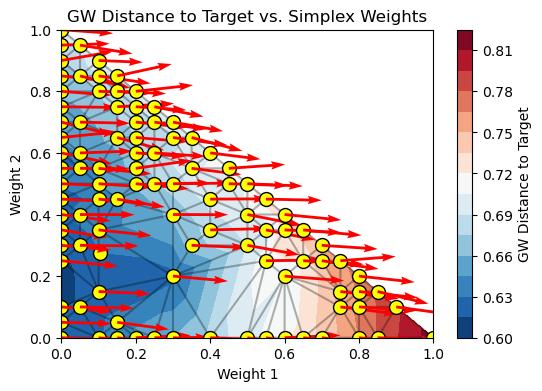

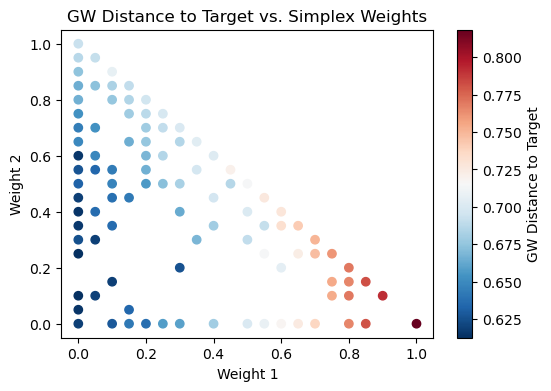

In [ ]:
# Clean up NaN values for plotting
z = simplex_gromov_wasserstein_distances_to_target
mask = np.isnan(z)
z_masked = z[~mask]
x_grid_points = simplex_grid_points[~mask,0]
y_grid_points = simplex_grid_points[~mask,1]

# Plot GW distances to target vs. simplex weights
plt.figure(figsize=(6,4))
plt.tricontourf(x_grid_points, y_grid_points, z_masked, levels=14, cmap="RdBu_r")
plt.colorbar(label='GW Distance to Target')
plt.xlabel('Weight 1')
plt.ylabel('Weight 2')
plt.title('GW Distance to Target vs. Simplex Weights')
# Add triangulation grid
triang = tri.Triangulation(x_grid_points, y_grid_points)
plt.triplot(triang, color='k', alpha=0.3)
plt.scatter(lambdas[0], lambdas[1], color='yellow', s=100, edgecolor='k', label='Computed Weights')

for idx in range(len(grad_lambda_list)):
    lambda_point = lambda_list[idx]#.detach().cpu().numpy().copy()          # The computed lambda point
    #lambda_derivative = grad_lambda_list[idx].detach().cpu().numpy().copy()  # The derivative at that point
    lambda_derivative = grad_lambda_list[idx]
    plt.scatter(lambda_point[0], lambda_point[1], color='yellow', s=100, edgecolor='k', label='Computed Weights')
    plt.quiver(lambda_point[0], lambda_point[1], lambda_derivative[0], lambda_derivative[1], angles='xy', scale_units='xy', scale=1, color='red')

plt.show()

# Scatter plot of GW distances to target vs. simplex weights
plt.figure(figsize=(6,4))
plt.scatter(x_grid_points, y_grid_points, c=z_masked, cmap='RdBu_r')
plt.colorbar(label='GW Distance to Target')
plt.xlabel('Weight 1')
plt.ylabel('Weight 2')
plt.title('GW Distance to Target vs. Simplex Weights')
plt.show()
